In [ ]:
# !pip3 install pillow
# !pip3 install seaborn
# !pip3 install pandas
# !python3 -m pip install ipykernel
# !python3 -m ipykernel install --user
#!pip3 install scikit-learn
#!pip3 install opencv-python

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd 
logs = pd.read_csv("data/driving_log.csv")

/usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


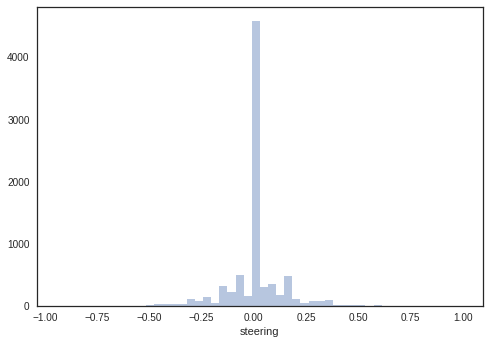

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns 
sns.set_style("white")

sns.distplot(logs.steering,kde=False)#,bins=np.linspace(-100.0,100.0,50))

In [5]:
logs.columns

Index(['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], dtype='object')

In [6]:
logs.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


In [7]:
from PIL import Image

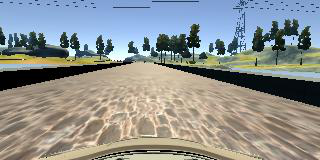

In [8]:
Image.open("data/IMG/center_2016_12_01_13_43_21_799.jpg")

In [9]:
im = Image.open("data/IMG/center_2016_12_01_13_43_21_799.jpg").transpose(Image.FLIP_LEFT_RIGHT)

In [10]:
#im.thumbnail((160,320), Image.ANTIALIAS)

In [11]:
import numpy as np
print(np.shape(im))

(160, 320, 3)


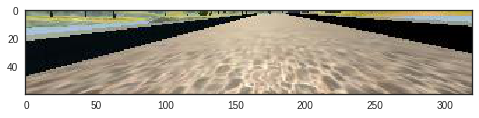

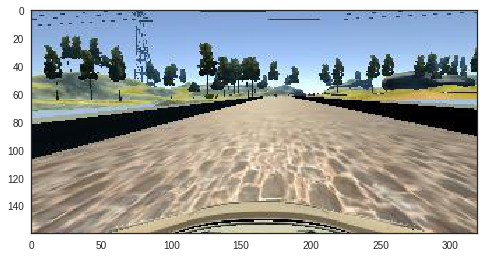

In [12]:
plt.imshow(np.asarray(im)[60:120])#[30:70,])
plt.show()
plt.imshow(np.asarray(im))

### Data Augmentation
1. Flip the images right to left and left to right and negate the steering angles
2. Left camera image angle + (angle delta(0.2))
3. Right camera image angle - (angle delta (0.2))
4. 


In [13]:
X_train = []
y_train = []
for d,s in zip(logs.center,logs.steering):
    im = Image.open("./data/"+d)
    X_train.append(np.array(im))
    y_train.append(s)
    
    

In [103]:
def data_augmentation():
    augmented_data = []
    augmented_steer = []
    perturb = 0.0
    for d,s in zip(logs.center,logs.steering):
        # if not zero flip
        im = Image.open("./data/"+d)
        if(s != 0.0):
            #im.thumbnail((160,320), Image.ANTIALIAS)
            augmented_data.append(np.array(im.transpose(Image.FLIP_LEFT_RIGHT)))
            augmented_steer.append(s*-1.0)
        if(s == 0.0):
            import random
            if(random.random() < 0.2):
                augmented_data.append(np.array(im))
                augmented_steer.append(s)
        else:
            augmented_data.append(np.array(im))
            augmented_steer.append(s)

    # left steering angles
    correction_factor = 0.2
    for d,s in zip(logs.left,logs.steering):
        old_s =s 
        s = s +correction_factor

        im = Image.open("./data/"+d.strip())
        if(old_s == 0.0):
            import random
            if(random.random() < 0.2):
                augmented_data.append(np.array(im.transpose(Image.FLIP_LEFT_RIGHT)))
                augmented_steer.append((s+perturb)*-1.0)
            if(random.random() < 0.2):
                augmented_data.append(np.array(im))
                augmented_steer.append(s+perturb)
        else:
            augmented_data.append(np.array(im.transpose(Image.FLIP_LEFT_RIGHT)))
            augmented_steer.append((s+perturb)*-1.0)
            augmented_data.append(np.array(im))
            augmented_steer.append(s+perturb)
            import random
            if(random.random() < np.abs(s)):
                augmented_data.append(np.array(im.transpose(Image.FLIP_LEFT_RIGHT)))
                augmented_steer.append((s+perturb)*-1.0)
            if(random.random() < np.abs(s)):
                augmented_data.append(np.array(im))
                augmented_steer.append(s+perturb)

    #right steering angle
    for d,s in zip(logs.right,logs.steering):
        old_s =s 
        s = s -correction_factor

        im = Image.open("./data/"+d.strip())
        if(old_s == 0.0):
            import random
            if(random.random() < 0.2):
                augmented_data.append(np.array(im.transpose(Image.FLIP_LEFT_RIGHT)))
                augmented_steer.append((s+perturb)*-1.0)
            if(random.random() < 0.2):
                augmented_data.append(np.array(im))
                augmented_steer.append(s+perturb)
        else:
            imf,sf = flip_image(im,s)
            augmented_data.append(np.array(im.transpose(Image.FLIP_LEFT_RIGHT)))
            augmented_steer.append((s+perturb)*-1.0)
            augmented_data.append(np.array(im))
            augmented_steer.append(s+perturb)
            import random
            if(random.random() < np.abs(s)):
                augmented_data.append(np.array(im.transpose(Image.FLIP_LEFT_RIGHT)))
                augmented_steer.append((s+perturb)*-1.0)
            if(random.random() < np.abs(s)):
                augmented_data.append(np.array(im))
                augmented_steer.append(s+perturb)

    return augmented_data,augmented_steer
            

In [102]:
import numpy as np
import sklearn
from PIL import Image

"""
Contrast Increase using HSV values.
"""
def process_data(image):
    im2 = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2HSV)
#     im2 = cv2.cvtColor(im2,cv2.COLOR_HSV2GRAY)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     im = clahe.apply(im2)
    #cropping the image
    im = im2
    im = np.array(im)[50:120]
    return im
    
    

def flip_image(image,steer,perturb = False):
    # Adding a small perturb to the steer ( noise )
    if(perturb):
        steer = steer +np.random.normal(0.001,0.001)
    return image.transpose(Image.FLIP_LEFT_RIGHT),steer*-1.0
    
def generator(X_train,y_train,batch_size=128):
    augmented_data = X_train 
    augmented_steer = y_train 
    X_train = np.array(augmented_data)
    y_train = np.array(augmented_steer)
    total = len(X_train)
    n_iter = int(total/batch_size)
    X_train,y_train = sklearn.utils.shuffle(X_train,y_train)
    while 1:
        for i in range(n_iter): 
            #print(i)
            yield X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        
    

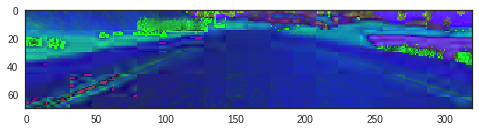

In [90]:
import cv2
im_center = np.asarray(plt.imread("./data/"+logs.left[500].strip()))
plt.imshow(process_data(im_center))

In [105]:
augmented_data,augmented_steer = data_augmentation()
X_train = np.array(augmented_data)
y_train = np.array(augmented_steer)

In [106]:
np.shape(X_train)

(29786, 160, 320, 3)

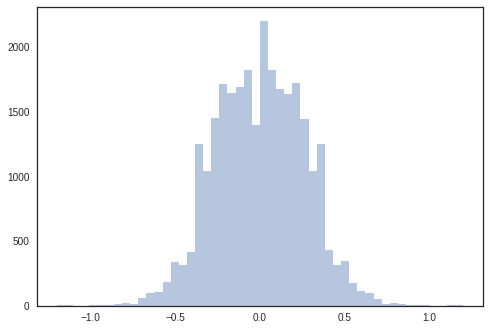

In [93]:
sns.distplot(augmented_steer,kde=False)#,bins=np.linspace(-100.0,100.0,50))

In [131]:
from keras.models import Sequential
from keras.optimizers import Adam

from keras.layers.core import Dense, Activation, Flatten,Dropout,Lambda
from keras.layers.convolutional import Convolution2D,Cropping2D
from keras.layers.pooling import MaxPooling2D

from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Lambda(lambda x : x/255.0-0.5 ,input_shape=(160, 320,3)))
model.add(Cropping2D(cropping=((70,20),(0,0))))
model.add(Convolution2D(32,3,3))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64,3,3))
#model.add(BatchNormalization())
model.add(ELU())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128,3,3))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.8))
model.add(Activation('relu'))

model.add(Dense(84))
model.add(Dropout(0.8))
model.add(Activation('relu'))

model.add(Dense(1))
#gradient clipping
opt = Adam(clipvalue=1.0)
model.compile(optimizer=opt,loss='mse')


In [132]:
# Clip less at bottom 
# Generator
#
train_generator = generator(X_train,y_train,batch_size=32)

In [134]:
#model.fit_generator(train_generator,samples_per_epoch=20000 , nb_epoch=5)
model.fit(X_train,y_train,batch_size=128,validation_split=0.2,nb_epoch=5,shuffle=True)

Train on 23828 samples, validate on 5958 samples
Epoch 1/5
23828/23828 [==============================] - 73s - loss: 0.0411 - val_loss: 0.0418
Epoch 2/5
23828/23828 [==============================] - 69s - loss: 0.0335 - val_loss: 0.0409
Epoch 3/5
23828/23828 [==============================] - 69s - loss: 0.0315 - val_loss: 0.0335
Epoch 4/5
23828/23828 [==============================] - 69s - loss: 0.0296 - val_loss: 0.0300
Epoch 5/5
23828/23828 [==============================] - 69s - loss: 0.0273 - val_loss: 0.0272


In [135]:
im_center = np.expand_dims(np.array(Image.open("./data/"+logs.center[0])),axis=0)
im_left = np.expand_dims(np.array(Image.open("./data/"+logs.left[0].strip())),axis=0)
im_right = np.expand_dims(np.array((Image.open("./data/"+logs.right[0].strip()))),axis=0)

In [136]:
print(model.predict(im_left))
print(model.predict(im_center))
print(model.predict(im_right))


[[ 0.20789199]]
[[ 0.03933833]]
[[-0.11701631]]


In [137]:
model.save("model.h5")

In [ ]:
np.random.normal(0.001,0.01)

In [ ]:
logs

In [ ]:
r = logs.reindex()

In [ ]:
len(logs)

In [ ]:
r.reindex()